In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import chess.pgn
import numpy as np
import seaborn as sns
import warnings
from sklearn import linear_model,metrics

#### Обучать модели можно также на разнице в рейтинге или на среднем

In [2]:
elos = pd.read_csv(r'C:\Users\Asus\elos.csv')
elos['Mean']=elos.mean(axis=1).astype(int)
elos['Diffs']=abs(elos.WhiteELo-elos.BlackElo).astype(int)
print(elos.describe())
elos.head()

           WhiteELo      BlackElo          Mean         Diffs
count  25000.000000  25000.000000  25000.000000  25000.000000
mean    2246.851040   2241.891320   2244.120760    189.082440
std      268.384897    270.983649    243.209379    136.337923
min     1021.000000   1128.000000   1216.000000      0.000000
25%     2075.000000   2067.000000   2090.000000     88.000000
50%     2272.000000   2267.000000   2266.000000    165.000000
75%     2447.000000   2447.000000   2421.000000    259.000000
max     2864.000000   2881.000000   2840.000000   1267.000000


,WhiteELo,BlackElo,Mean,Diffs
0,2354,2411,2382,57
1,2523,2460,2491,63
2,1915,1999,1957,84
3,2446,2191,2318,255
4,2168,2075,2121,93


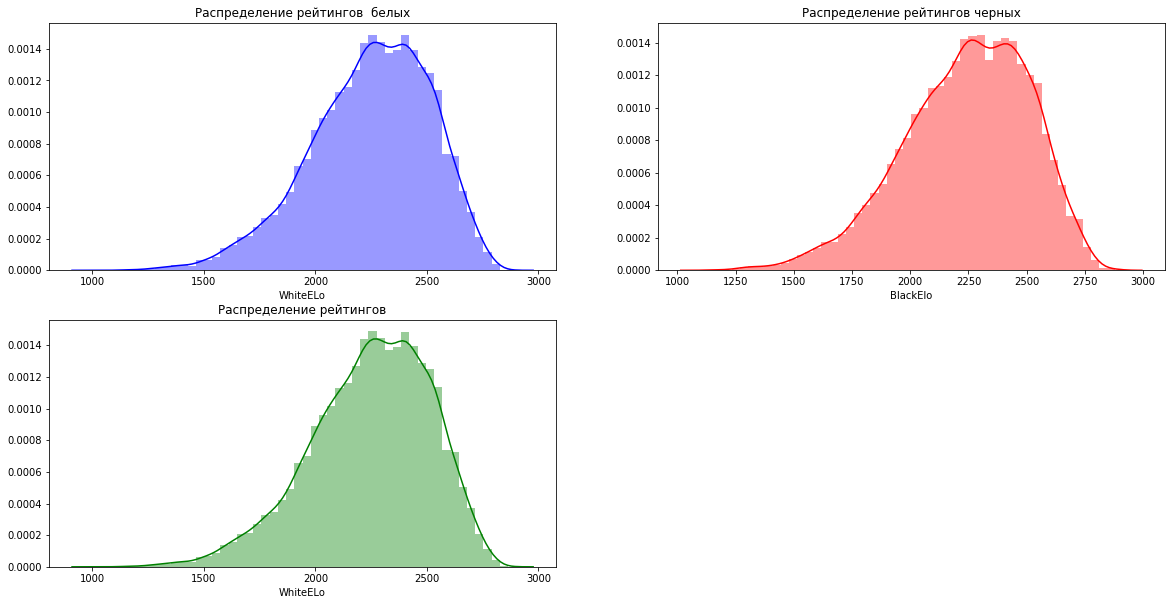

In [3]:
fig=plt.figure(figsize=(20,10))

ax1=plt.subplot(2,2,1)
sns.distplot(elos.WhiteELo,color='b')
ax1.set_title('Распределение рейтингов  белых')

ax2=plt.subplot(2,2,2)
sns.distplot(elos.BlackElo,color='r')
ax2.set_title('Распределение рейтингов черных')

allElos=elos.WhiteELo
allElos.append(elos.BlackElo)
ax3=plt.subplot(2,2,3)
sns.distplot(allElos,color='g')
ax3.set_title('Распределение рейтингов')

plt.show()

In [4]:
games= pd.read_csv(r'C:\Users\Asus\games.csv')
games.Moves=games.Moves.str.replace(' ','').str.replace('[','').str.replace(']','').str.replace(',',' ')
games.Scores=games.Scores.str.replace(' ','').str.replace('[','').str.replace(']','').str.replace(',',' ')
games.Scores=games.Scores.apply(lambda x: list(map(int,x.split())))
games.Moves=games.Moves.apply(lambda x: x.split())
games.head()

,Result,Moves,Scores,NumMoves
0,1/2-1/2,"['Nf3', 'Nf6', 'c4', 'c5', 'b3', 'g6', 'Bb2', ...","[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,...",19
1,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nf6', 'd4', 'Nxe4', 'Nxe5...","[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5...",7
2,0-1,"['e4', 'd5', 'exd5', 'Nf6', 'd4', 'Nxd5', 'Nf3...","[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5...",53
3,1-0,"['c4', 'Nf6', 'Nc3', 'd6', 'd4', 'e5', 'Nf3', ...","[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ...",39
4,1-0,"['e4', 'c5', 'Nf3', 'd6', 'b4', 'Nf6', 'bxc5',...","[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9...",25


In [5]:
games_small=games[games['NumMoves']<10]
games_small

,Result,Moves,Scores,NumMoves
1,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nf6', 'd4', 'Nxe4', 'Nxe5...","[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5...",7
44,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nc6', 'Bb5', 'a5', 'Bxc6'...","[26, 45, 26, 20, 30, 68, 29, 38, 47, 39]",5
251,1/2-1/2,"['d4', 'Nf6', 'Nf3', 'e6', 'g3', 'b5', 'Bg2', ...","[19, 17, 8, 21, -5, 42, 22, 14, 18, 43, 29, 36...",8
308,1-0,"['d4', 'd5', 'Bf4', 'Nf6']","[19, 13, 16, 16]",2
556,1/2-1/2,"['Nf3', 'Nf6', 'g3', 'g6', 'b3', 'Bg7', 'Bb2',...","[18, 11, -4, 20, -15, -11, -12, -20, -16, 14, ...",8
624,1-0,['e4'],[],1
762,1/2-1/2,"['d4', 'd5', 'Nf3', 'Nf6', 'e3', 'e6', 'Bd3', ...","[19, 13, 10, 22, 15, 8, 13, 13, 5, 2, 10, 16, ...",7
828,1/2-1/2,"['e4', 'e5', 'Nf3']","[13, 44, 26]",2
929,1/2-1/2,"['e4', 'e6', 'd4', 'd5', 'exd5', 'exd5', 'Nf3'...","[26, 48, 46, 29, 23, 7, 23, 24, 14, 25, 27, 51...",8
943,1/2-1/2,"['c4', 'c5', 'Nc3', 'Nc6', 'Nf3', 'Nf6', 'g3',...","[2, 26, 12, 7, 23, 22, -3, 14, 22, 29, 28, 29, 7]",7


In [6]:
games = games[~games.index.isin(games_small.index)]
games.shape

(49522, 4)

In [7]:
games['MeanScore']=games.Scores.apply(lambda x: np.mean(x))

In [8]:
games.MeanScore.describe()

count    49522.000000
mean        31.473797
std        234.613357
min      -2162.262500
25%        -58.773904
50%         23.422291
75%        121.308882
max       2187.973451
Name: MeanScore, dtype: float64

In [9]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49522 entries, 0 to 49999
Data columns (total 5 columns):
Result       49522 non-null object
Moves        49522 non-null object
Scores       49522 non-null object
NumMoves     49522 non-null int64
MeanScore    49522 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.3+ MB


#### Добавить признаки для удаления выбросов

In [14]:
#games = games[~games.index.isin(games_reject.index)]
games['ModeScore']=games.Scores.apply(lambda x: max(set(x), key=x.count))
games['FinalScore']=games.Scores.apply(lambda x: x[-1])
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49522 entries, 0 to 49999
Data columns (total 7 columns):
Result        49522 non-null object
Moves         49522 non-null object
Scores        49522 non-null object
NumMoves      49522 non-null int64
MeanScore     49522 non-null float64
ModeScore     49522 non-null int64
FinalScore    49522 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 3.0+ MB


In [15]:
games_draws=games[games['Result']=='1/2-1/2']
games_draws.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,15150.000000,15150.000000,15150.000000,15150.000000
mean,41.330957,15.207983,7.338680,3.898086
std,20.088994,63.227200,92.091292,292.692983
min,10.000000,-1854.552381,-3984.000000,-10770.000000
25%,27.000000,-4.186328,0.000000,0.000000
50%,40.000000,15.512348,0.000000,0.000000
75%,53.000000,34.997093,10.000000,11.750000
max,165.000000,1888.491228,5972.000000,10289.000000


Удаляем ничейные партии, где оценка конечной позиции слишком высокая

In [16]:
games_draws_reject=games_draws[(abs(games_draws['FinalScore'])>1000)]
games_draws_reject.head()

,Result,Moves,Scores,NumMoves,MeanScore,ModeScore,FinalScore
67,1/2-1/2,"['e4', 'e6', 'd4', 'd5', 'exd5', 'exd5', 'Bd3'...","[26, 48, 46, 29, 23, 7, 16, 22, 1, 14, -12, -2...",53,116.698113,0,10289
1400,1/2-1/2,"['d4', 'd5', 'c4', 'c6', 'Nf3', 'Nf6', 'Nc3', ...","[19, 13, 9, 34, 45, 40, 41, 37, 20, 41, 43, 46...",69,8.014599,0,-4926
2223,1/2-1/2,"['d4', 'd6', 'c4', 'e5', 'Nf3', 'e4', 'Ng5', '...","[19, 42, 38, 27, 39, 17, -12, -16, 18, -10, 29...",63,73.150794,0,5403
2319,1/2-1/2,"['Nf3', 'g6', 'c4', 'Bg7', 'd4', 'd6', 'Nc3', ...","[18, 82, 43, 31, 53, 42, 50, 55, 56, 73, -11, ...",49,-106.173469,0,-1651
2459,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'Nf6', 'd3',...","[26, 44, 25, 14, 19, 15, 12, 19, 0, 0, -3, 37,...",41,-73.024691,0,-1266


In [17]:
games = games[~games.index.isin(games_draws_reject.index)]
games.shape

(49465, 7)

Удаляем результативные партии, где меньше 20 ходов и низкая оценка финальной позиции (вероятно нарушение правил или другое обстоятельство, не влияющее на качество игры)

In [18]:
games_reject=games[(games['NumMoves']<20)
                         &((games['Result']=='1-0')| (games['Result']=='0-1'))
                         &(abs(games['FinalScore'])<50)]
games_reject.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,78.000000,78.000000,78.000000,78.000000
mean,14.769231,20.686153,15.487179,7.858974
std,3.040519,22.799496,21.311386,24.707496
min,10.000000,-73.828571,-60.000000,-48.000000
25%,12.000000,11.610294,0.000000,-5.500000
50%,15.000000,20.869444,12.500000,5.500000
75%,17.000000,31.143971,28.250000,26.750000
max,19.000000,122.970588,84.000000,49.000000


In [19]:
games = games[~games.index.isin(games_reject.index)]
games.shape

(49387, 7)

Удаляем ничейные партии с количеством ходов меньше 15 (скорее всего договорные)

In [20]:
games_draws_moves_reject=games_draws[games_draws['NumMoves']<15]
games_draws_moves_reject.shape

(897, 7)

In [21]:
games = games[~games.index.isin(games_draws_moves_reject.index)]
games.shape

(48490, 7)

In [22]:
games.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,48490.000000,48490.000000,48490.000000,48490.000000
mean,42.452588,31.682972,16.348402,115.932893
std,16.320788,236.768860,445.756998,2319.694978
min,10.000000,-2162.262500,-11447.000000,-12261.000000
25%,31.000000,-61.364839,0.000000,-365.750000
50%,40.000000,23.712565,0.000000,0.000000
75%,51.000000,124.289610,26.000000,550.000000
max,165.000000,2187.973451,11259.000000,12337.000000


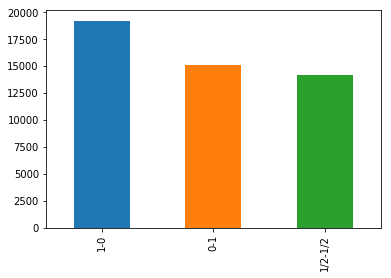

In [23]:
games['Result'].value_counts().plot('bar')

Белые в данном наборе выигрывали чаще

In [28]:
def mean_delta(x):
    diffs=[]
    for i in range(len(x)-1):
        diffs.append((x[i+1]-x[i]))
    return np.mean(diffs)

games['MeanDeltaScore']=games.Scores.apply(mean_delta)
games['MinScore']=games.Scores.apply(lambda x: min(x))
games['MaxScore']=games.Scores.apply(lambda x: max(x))
games['MedianScore']=games.Scores.apply(lambda x: np.median(x))
games.head()

,Result,Moves,Scores,NumMoves,MeanScore,ModeScore,FinalScore,MeanDeltaScore,MinScore,MaxScore,MedianScore
0,1/2-1/2,"['Nf3', 'Nf6', 'c4', 'c5', 'b3', 'g6', 'Bb2', ...","[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,...",19,23.947368,3,54,0.972973,-26,73,18.0
2,0-1,"['e4', 'd5', 'exd5', 'Nf6', 'd4', 'Nxd5', 'Nf3...","[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5...",53,-692.198113,18,-11544,-110.190476,-11544,93,-48.0
3,1-0,"['c4', 'Nf6', 'Nc3', 'd6', 'd4', 'e5', 'Nf3', ...","[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ...",39,49.246753,31,196,2.552632,-30,198,37.0
4,1-0,"['e4', 'c5', 'Nf3', 'd6', 'b4', 'Nf6', 'bxc5',...","[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9...",25,306.040816,18,875,17.687500,10,917,142.0
5,1/2-1/2,"['Nf3', 'd5', 'd4', 'Nf6', 'c4', 'e6', 'Nc3', ...","[18, 29, 10, 22, 20, 18, 19, 28, 24, 18, 17, 1...",29,30.827586,18,-11,-0.508772,-15,94,29.0


#### Добавим еще признаков. Частично идеи взяты отсюда - https://www.kaggle.com/c/finding-elo/discussion/10834

In [ ]:
# не тестилось!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def part_by_color(x,color='w'):
    color_scores=[]
    i=0 if color=='w' else 1
    while i <= len(x)-1:
        color_scores.append(x[i])
    return color_scores

games['WhiteScores']=games.Scores.apply(part_by_color)
games.head()

In [58]:
train_data=games[games.index.isin(elos.index)]
elos=elos[elos.index.isin(train_data.index)]
print(train_data.shape)
print(elos.shape)

(24268, 11)
(24268, 4)


In [35]:
test_data=games[~games.index.isin(elos.index)]
test_data.shape

(24222, 11)

In [56]:
train_data.head()

,Result,Moves,Scores,NumMoves,MeanScore,ModeScore,FinalScore,MeanDeltaScore,MinScore,MaxScore,MedianScore
0,1/2-1/2,"['Nf3', 'Nf6', 'c4', 'c5', 'b3', 'g6', 'Bb2', ...","[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,...",19,23.947368,3,54,0.972973,-26,73,18.0
2,0-1,"['e4', 'd5', 'exd5', 'Nf6', 'd4', 'Nxd5', 'Nf3...","[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5...",53,-692.198113,18,-11544,-110.190476,-11544,93,-48.0
3,1-0,"['c4', 'Nf6', 'Nc3', 'd6', 'd4', 'e5', 'Nf3', ...","[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ...",39,49.246753,31,196,2.552632,-30,198,37.0
4,1-0,"['e4', 'c5', 'Nf3', 'd6', 'b4', 'Nf6', 'bxc5',...","[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9...",25,306.040816,18,875,17.687500,10,917,142.0
5,1/2-1/2,"['Nf3', 'd5', 'd4', 'Nf6', 'c4', 'e6', 'Nc3', ...","[18, 29, 10, 22, 20, 18, 19, 28, 24, 18, 17, 1...",29,30.827586,18,-11,-0.508772,-15,94,29.0


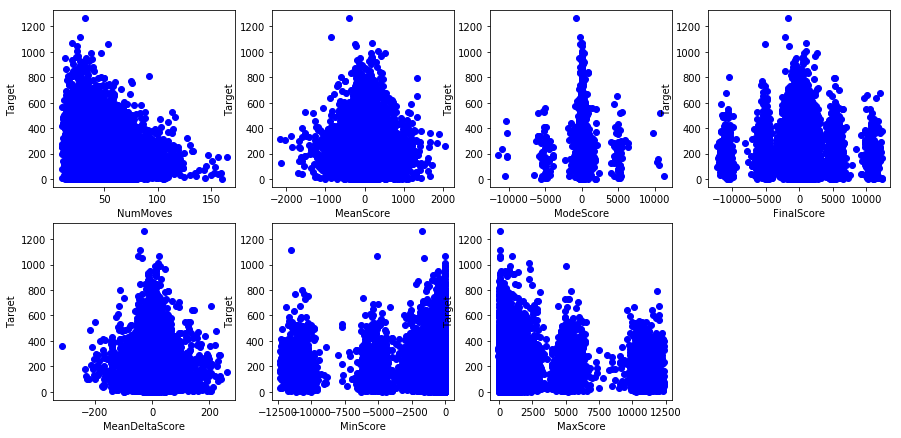

In [65]:
fig=plt.figure(figsize=(15,15))
plot_number=0
for i in range(7):
    plt.subplot(4, 4, plot_number + 1)
    plt.scatter(train_data.iloc[:,plot_number+3], elos.Diffs, color = 'b')
    xl=train_data.columns[plot_number+3]
    plt.xlabel (xl)
    plt.ylabel ("Target")
    plot_number += 1

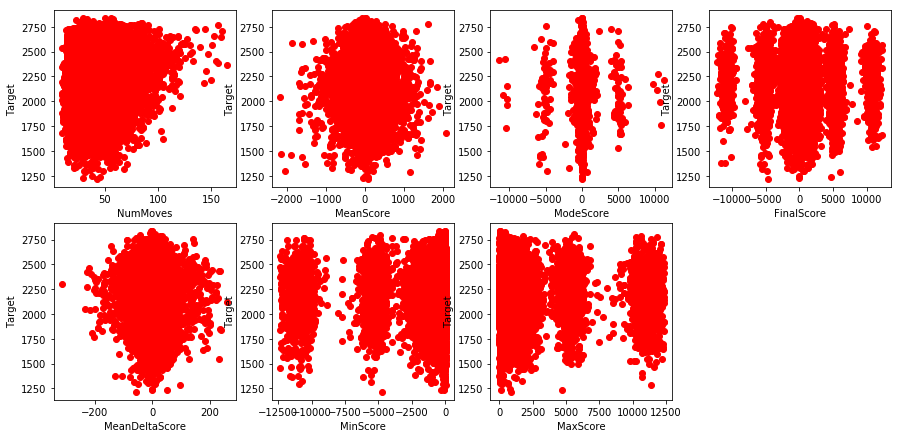

In [66]:
fig=plt.figure(figsize=(15,15))
plot_number=0
for i in range(7):
    plt.subplot(4, 4, plot_number + 1)
    plt.scatter(train_data.iloc[:,plot_number+3], elos.Mean, color = 'r')
    xl=train_data.columns[plot_number+3]
    plt.xlabel (xl)
    plt.ylabel ("Target")
    plot_number += 1

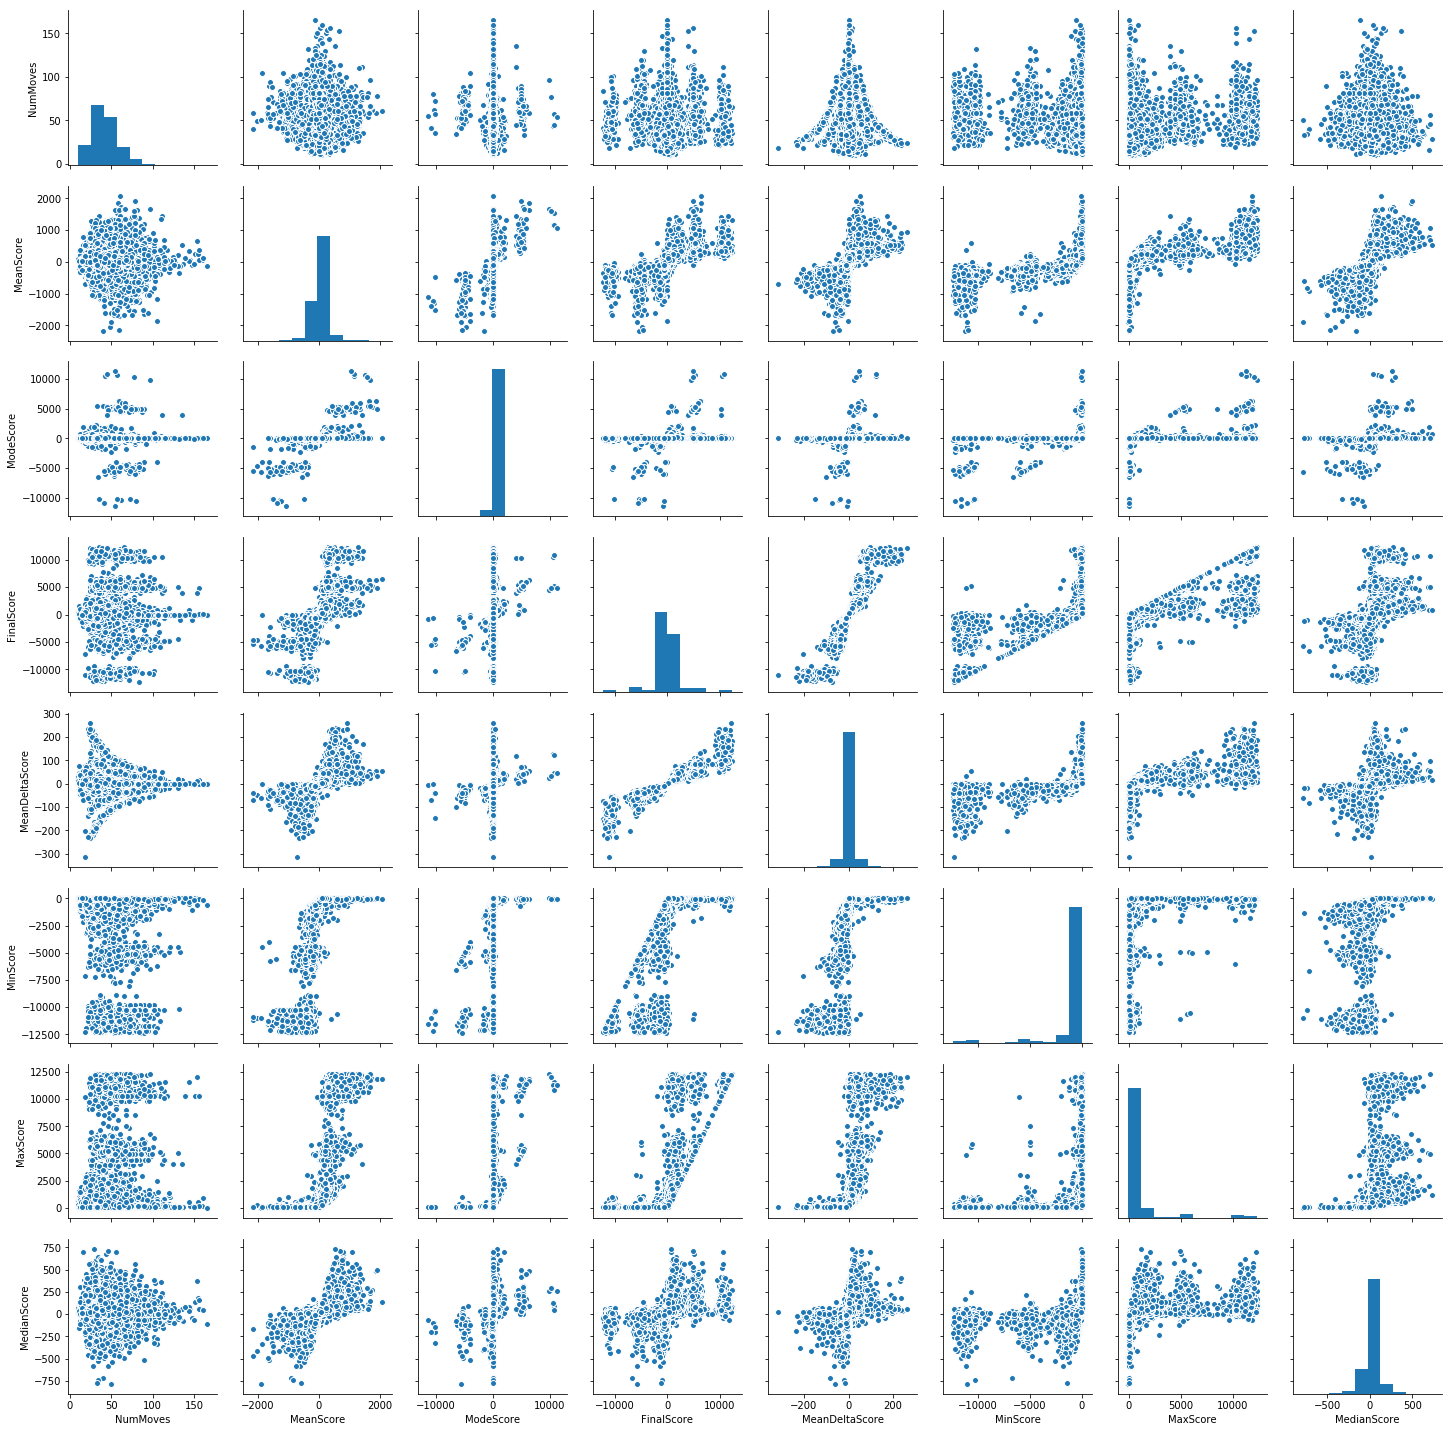

In [61]:
sns.pairplot(train_data)

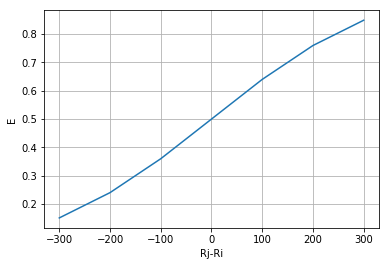

In [14]:
rating_difference = np.arange(start=-300, stop = 400, step =100)
E=1/(1+10**(-rating_difference/400))
plt.plot(rating_difference, E)
plt.xlabel('Rj-Ri')
plt.ylabel('E')
plt.grid(True)
plt.show()

In [ ]:
fig=plt.figure(figsize=(20,10))

ax1=plt.subplot(2,2,1)
sns.distplot(elos.WhiteELo,color='b')
ax1.set_title('Распределение рейтингов  белых')

ax2=plt.subplot(2,2,2)
sns.distplot(elos.BlackElo,color='r')
ax2.set_title('Распределение рейтингов черных')

allElos=elos.WhiteELo
allElos.append(elos.BlackElo)
ax3=plt.subplot(2,2,3)
sns.distplot(allElos,color='g')
ax3.set_title('Распределение рейтингов')

plt.show()

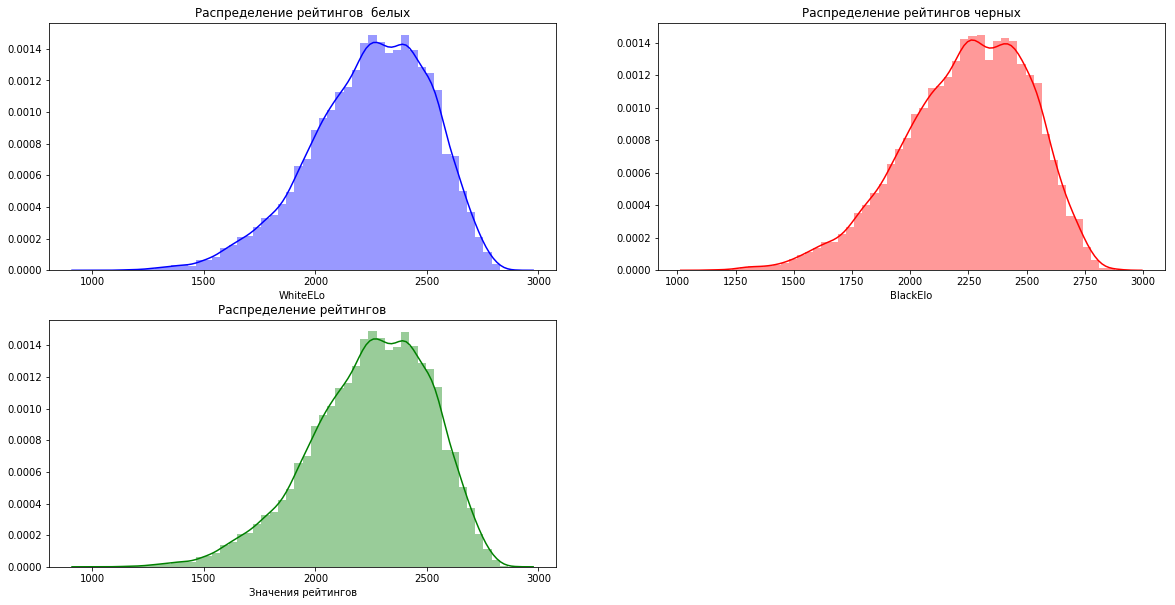

In [27]:
# После очистки данных
fig=plt.figure(figsize=(20,10))

ax1=plt.subplot(2,2,1)
sns.distplot(elos.WhiteELo,color='b')
ax1.set_title('Распределение рейтингов  белых')

ax2=plt.subplot(2,2,2)
sns.distplot(elos.BlackElo,color='r')
ax2.set_title('Распределение рейтингов черных')

allElos=elos.WhiteELo
allElos.append(elos.BlackElo)
ax3=plt.subplot(2,2,3)
sns.distplot(allElos,color='g')
ax3.set_title('Распределение рейтингов')
ax3.set_xlabel("Значения рейтингов")
plt.show()